# Variational Autoencoders

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256)       │    200,960 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      2,570 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │      2,570 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 28, 28, 1) │    204,304 │ sampling[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 28, 28, 1) │          0 │ input_layer_2[0]… │
│ (VAELossLayer)      │                   │            │ sequential_1[0][… │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 410,404 (1.57 MB)

 Trainable params: 410,404 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.1069
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0677
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0676
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0676
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0675


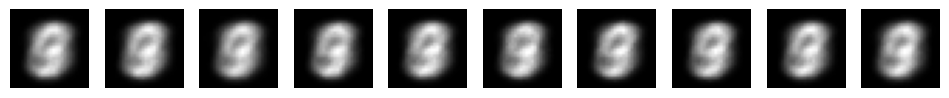

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 10

# -------------------------------
# Encoder (Sequential)
# -------------------------------
encoder_base = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
])
encoder_mu = layers.Dense(latent_dim)
encoder_logvar = layers.Dense(latent_dim)

# -------------------------------
# Sampling layer
# -------------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * logvar) * eps

# -------------------------------
# Custom VAE layer
# -------------------------------
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, x_recon, mu, logvar = inputs

        # Reconstruction loss
        recon_loss = keras.ops.mean(keras.ops.square(x - x_recon))

        # KL divergence
        kl_loss = -0.5 * keras.ops.mean(
            1 + logvar - keras.ops.square(mu) - keras.ops.exp(logvar)
        )

        # Add total loss
        self.add_loss(recon_loss + kl_loss)

        return x_recon  # output must be the reconstruction


# -------------------------------
# Decoder (Sequential)
# -------------------------------
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(28*28, activation="sigmoid"),
    layers.Reshape((28, 28, 1)),
])

# -------------------------------
# Build full VAE (Functional Model)
# -------------------------------
inputs = layers.Input(shape=(28, 28, 1))
# stage 1
h = encoder_base(inputs)

#stage 2
mu = encoder_mu(h)
logvar = encoder_logvar(h)
#stage 3

z = Sampling()([mu, logvar])

#stage 4
reconstructed = decoder(z)

# Apply VAE loss inside a layer
outputs = VAELossLayer()([inputs, reconstructed, mu, logvar])

vae = models.Model(inputs, outputs)
vae.compile(optimizer="adam")
vae.summary()

# -------------------------------
# Load MNIST
# -------------------------------
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)

# -------------------------------
# Train
# -------------------------------
vae.fit(x_train, epochs=5, batch_size=128)

# -------------------------------
# Generate samples
# -------------------------------
z_samples = tf.random.normal((10, latent_dim))
generated = decoder(z_samples)

plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated[i,:,:,0], cmap="gray")
    plt.axis("off")
plt.show()


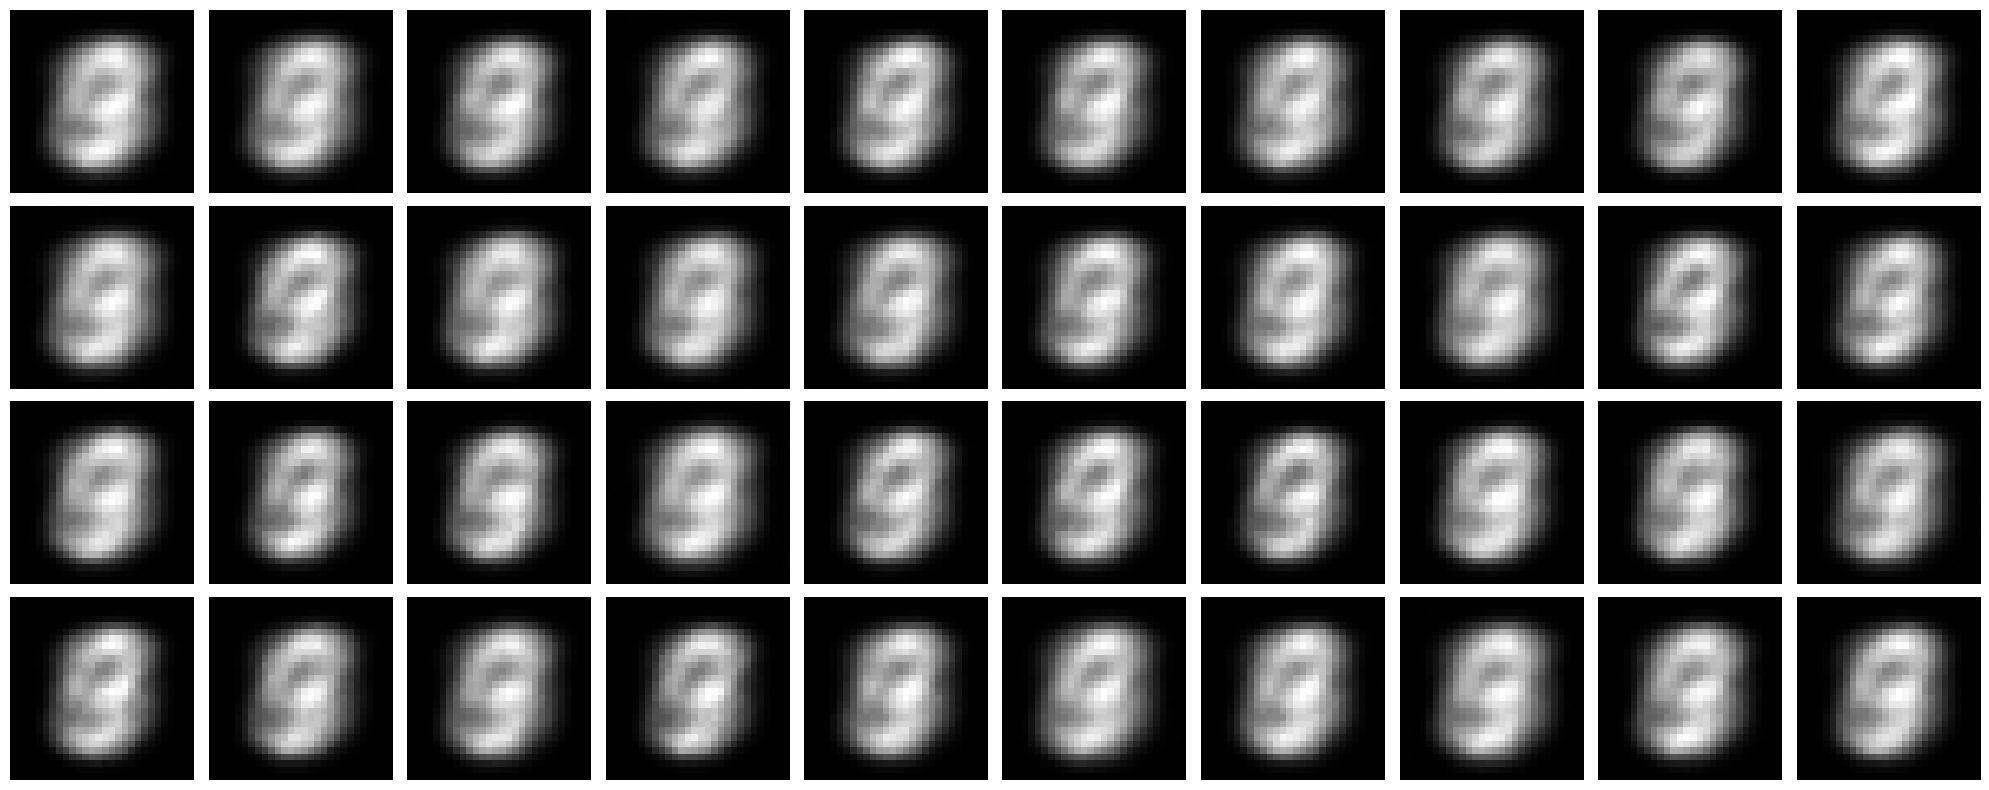

In [ ]:
num_samples = 40
z_dim = latent_dim

# Sample from N(0, 1)
z_samples = np.random.randn(num_samples, z_dim)

# Generate images
gen_images = decoder(z_samples)

# Plot 4x10 grid
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(4, 10, i + 1)
    plt.imshow(gen_images[i, :, :, 0], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Using Convolutional Layers

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128)       │    420,352 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │      1,290 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │      1,290 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 10)        │          0 │ dense_6[0][0],    │
│ (Sampling)          │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 28, 28, 1) │     90,177 │ sampling_1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 28, 28, 1) │          0 │ input_layer_5[0]… │
│ (VAELossLayer)      │                   │            │ sequential_3[0][… │
│                     │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,109 (1.96 MB)

 Trainable params: 513,109 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0913
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0675
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0675
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0674
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0674


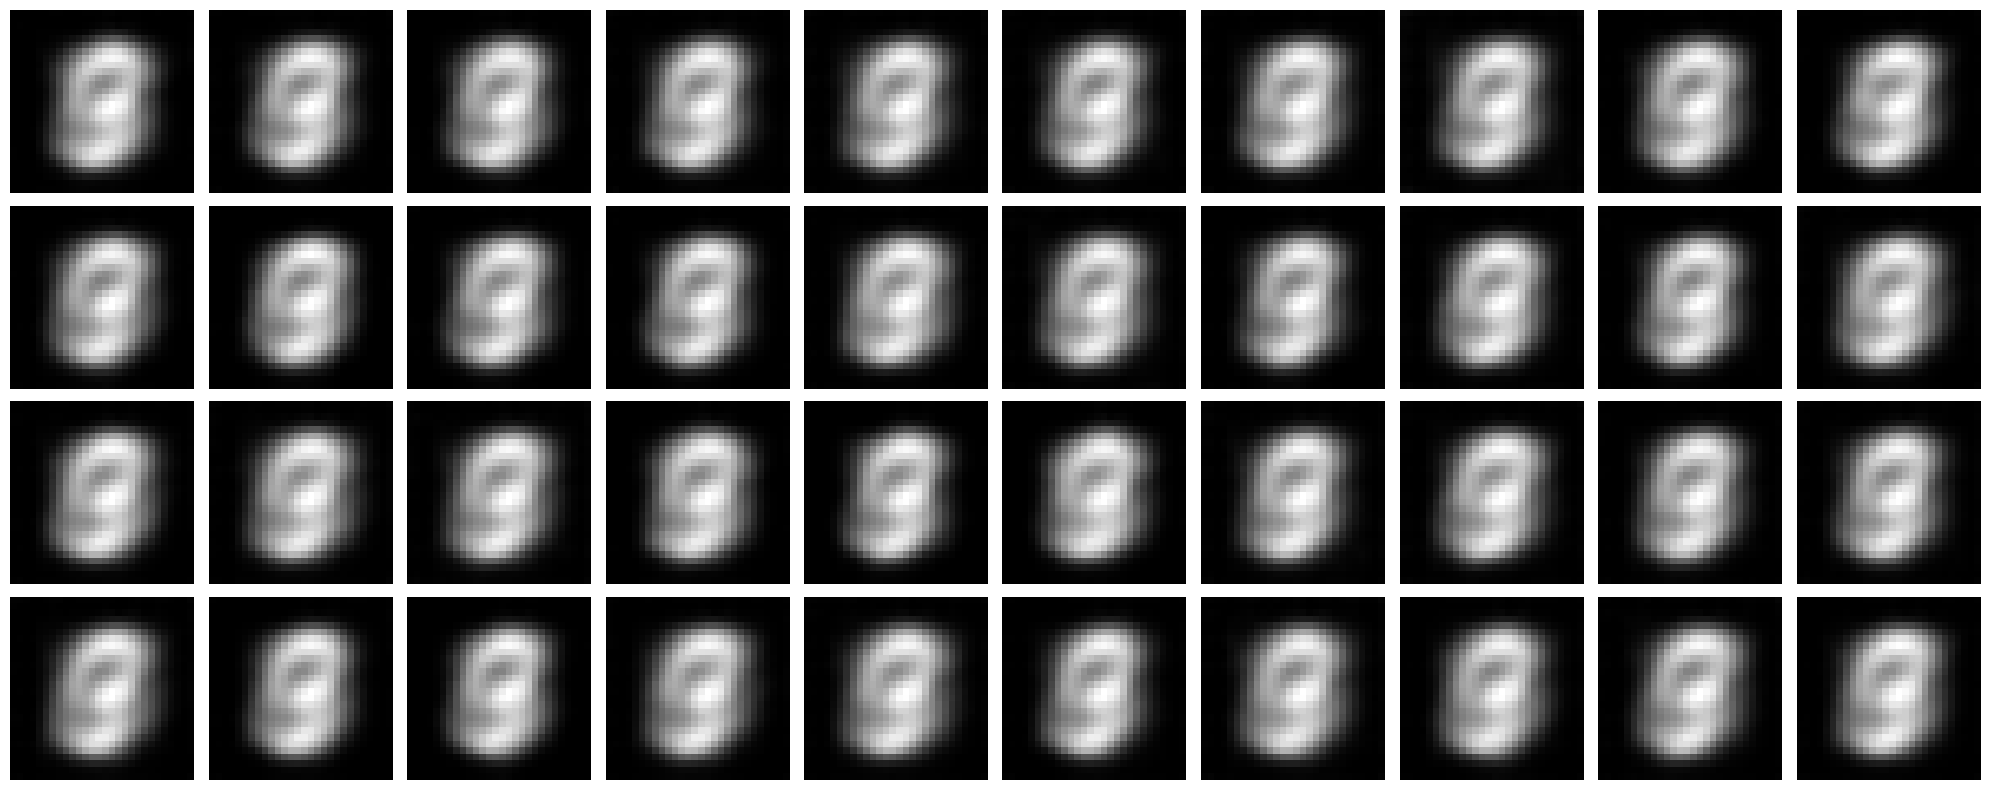

In [ ]:
# -------------------------------
# Convolutional Encoder
# -------------------------------
conv_encoder_base = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2, padding='same'),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2, padding='same'),

    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

conv_encoder_mu = layers.Dense(latent_dim)
conv_encoder_logvar = layers.Dense(latent_dim)

# -------------------------------
# Sampling layer (same as before)
# -------------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * logvar) * eps

# -------------------------------
# Convolutional Decoder
# -------------------------------
conv_decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 64, activation='relu'),
    layers.Reshape((7, 7, 64)),

    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),

    layers.Conv2D(1, 3, activation='sigmoid', padding='same')
])

# -------------------------------
# VAE Loss Layer (reuse same class)
# -------------------------------
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, x_recon, mu, logvar = inputs

        # Reconstruction loss (Keras ops required)
        recon_loss = keras.ops.mean(keras.ops.square(x - x_recon))

        # KL Divergence
        kl_loss = -0.5 * keras.ops.mean(
            1 + logvar - keras.ops.square(mu) - keras.ops.exp(logvar)
        )

        self.add_loss(recon_loss + kl_loss)
        return x_recon

# -------------------------------
# Build full Conv-VAE model
# -------------------------------
inputs = layers.Input(shape=(28, 28, 1))

h = conv_encoder_base(inputs)
mu = conv_encoder_mu(h)
logvar = conv_encoder_logvar(h)
z = Sampling()([mu, logvar])
reconstructed = conv_decoder(z)

outputs = VAELossLayer()([inputs, reconstructed, mu, logvar])

conv_vae = models.Model(inputs, outputs)
conv_vae.compile(optimizer="adam")
conv_vae.summary()

# -------------------------------
# Train Conv-VAE
# -------------------------------
conv_vae.fit(x_train, epochs=5, batch_size=128)

# -------------------------------
# Generate 40 samples using Conv-VAE
# -------------------------------
z_samples = np.random.randn(40, latent_dim)
conv_images = conv_decoder(z_samples)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(conv_images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
